<a href="https://colab.research.google.com/github/shun601/4th-tellus-satellite-challenge/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 原初データ提供者：国立研究開発法人宇宙航空研究開発機構    
#### Original data provided by JAXA

# 1 はじめに
本ファイルは、[「The 4th Tellus Satellite Challenge：海岸線の抽出」](https://signate.jp/competitions/284)コンペにて最終投稿の学習を行ったコードです。  
チーム「DSH-Beginners」として参加し、最終評価の順位は33位 / 125位でした。投稿の上位40%に入ることができ、見事銅メダルを頂くことができました。チームの皆様には、この場を借りて改めて御礼申し上げたいと思います。    



## 1.1 今回のコンペの特徴
本コンペでは、学習データとして25枚、評価用として30枚、計55枚のLバンドSAR画像と、学習用データに対するアノテーション（海岸線の座標情報）がJSON形式で与えられました。  
まず、学習用データが25枚と非常に少ないという特徴があり、データを増やすアプローチを考える必要がありました。また、学習用データを見るとシーンが被っているものが多く、シーン数で見るとわずか８シーンしかありませんでした。さらに、学習データの画像サイズは画像により異なり、ノイズや欠損値も含まれているなど、適切な前処理が求められました。 どのような前処理を行ったのかは、別途データ前処理のコードで解説させて頂きますので、そちらをご参照ください。  
以上のように、本コンペでは、**「少ない学習データを使って、海岸線の予測精度・汎化性能が高いモデルをいかにして構築するか」**が要求され、非常に難しいコンペとなりました。

## 1.2 アプローチ概要
過去コンペ上位入賞者と同じくディープラーニングの**[セマンティックセグメンテーション](https://speakerdeck.com/motokimura/semantic-segmentation-zhen-rifan-ri?slide=14)**で取り組みました。

- 学習データに対して海と陸で塗り分けたマスク画像を用意し、**海、陸、欠損の３クラスのセマンティックセグメンテーション**として、モデルの実装を行いました。

- 与えられたjson形式アノテーションと学習用データを重ね合わせて可視化した後、その画像を元に自前で（ペイントやphotoshopで）陸と海を塗り分けてマスク画像を用意しました。今回の海岸線については、陸と海の境界が非常にシビアで、アノテーションするのに苦労しました。このアノテーション作業の精度がモデルの精度に影響していると思います。欠損値のマスク画像への変換は、独自クラスを作成して対応しました。

- データオーギュメンテーションでは、各学習用データを２０倍に水増しし、**[Albumentations](https://github.com/albumentations-team/albumentations)**というサードパーティのライブラリを使用しました。使用したデータ拡張は以下の通りです。
    -  水平方向に反転 HorizontalFlip(p=0.5)
    -  上下方向に反転 VerticalFlip(p=0.5),
    -  -90°〜90°の範囲で画像を回転させる。Rotate(limit=[-90, 90], interpolation=0, p=0.5),
    - 3x3のグリッドにしてシャッフル。RandomGridShuffle(grid=(3, 3), p=0.5)
    - ランダムに明るさとコントラストを変える　RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
    - 弾性変形（歪ませる）　ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=0.5)

- アーキテクチャは**[FPN](http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf)**, エンコーダには**[EfficientNet-B5](https://hampen2929.hatenablog.com/entry/2019/07/06/024347)**を用い、クラス数は3クラス、入力チャネルを１として、**[ファインチューニング](https://www.kikagaku.ai/tutorial/basic_of_computer_vision/learn/tensorflow_finetuning)**を行いました。
    - learning_rate : 0.001
    - weight decay: 0.0003
    - encoder_learning_rate : 0.0005
    - ミニバッチ数 : 5
    - epoch数: 8

- 損失関数(Loss)には、Dice, IoU, CEを使用し、以下の式で合計した損失関数を使用しました。
    - $IoU + Dice + 0.8*CE$.

- 最適化関数(Optimizer)には**[RAdam](https://arxiv.org/abs/1908.03265)**を使用しました。

- 学習はGoogle ColabのGPUを使用しました。

- 交差検証には8グループ(1グループ=1シーン)の**[Leave One Group Out(LOGO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html)**を採用しました。

- 推論では、LOGOで学習されたweightのベストパラメータをアンサンブルさせました。

- public boardのスコアが26.7187758、private boardでのスコアが22.7821334となり、最終スコアが上がりました。過学習が抑えられたモデルが構築できていたと考えられます。


## 1.3 コンペを終えて
- 初参加のコンペでしたが、見事銅メダルを獲得することができました。
- コンペ参加前は、ゼロから作るディープラーニング①を読んだことがある程度で、機械学習も深層学習も全くの初心者で、実装経験もありませんでした。画像を扱った経験もほとんどありませんでした。しかし、コンペに参加しアウトプットを出すために、色々と調べながら実装する経験を積むことで、必要な知識が増え、非常に多くのことを勉強することができました。チームを組んで参加することで、チームメンバーからの学びも非常に多く、モチベーションを保つことも容易でした。コンペへの参加は、スキルを高めていく上で非常に有用だと感じました。これからも、様々なコンペに参加し、アウトプットを積み重ねながらスキルを高めていきたいと思います。

## 1.4 さらなる改善点
チームメンバーでのコンペ後のディスカッションや、上位のアプローチから学んで、以下の内容がさらなる改善点として挙がりました。
- 損失関数のクロスエントロピーの計算時に、Label smoothingを行う。

### 参考文献
#### ディープラーニング手法
- セマンティックセグメンテーション https://speakerdeck.com/motokimura/semantic-segmentation-zhen-rifan-ri?slide=14 

#### 深層学習フレームワーク(PyTorch)
- PyTorch https://pytorch.org/
- Catalyst(PyTorchのラッパーライブラリ) https://catalyst-team.github.io/catalyst/

#### データ前処理
- Albumentations https://github.com/albumentations-team/albumentations
- Albumentations サンプル集 https://qiita.com/kurilab/items/b69e1be8d0224ae139ad

#### アーキテクチャ
- モデルのアーキテクチャ segmantation_models.pytorch https://github.com/qubvel/segmentation_models.pytorch
- FPN解説 http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf
- FPN論文 https://arxiv.org/pdf/1612.03144.pdf
- EfficientNet https://hampen2929.hatenablog.com/entry/2019/07/06/024347

#### 転移学習、ファインチューニング
- 転移学習 https://jp.mathworks.com/discovery/transfer-learning.html
- ファインチューニング https://www.kikagaku.ai/tutorial/basic_of_computer_vision/learn/tensorflow_finetuning

#### 最適化関数（Optimizer）
- RAdam https://qiita.com/omiita/items/d24568a835da6911b01e

#### Label Smoothing
- Label Smoothing解説 https://deecode.net/?p=1229

#### 交差検証
- Leave One Group Out(LOGO) https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html

#### Tensorboard
- Tensorboardの使い方 https://qiita.com/tetrar124/items/aa27b4d616c859860d02

#### 学習コンテンツ
- 衛星画像の分類 https://quest.signate.jp/quests/10019
- Tellus e-learning https://tellusxdp.github.io/tellus-trainer/index.html
- 画像100本ノック https://github.com/yoyoyo-yo/Gasyori100knock
- ゼロから作るディープラーニング-Pythonで学ぶディープラーニングの理論と実装 https://www.amazon.co.jp/dp/4873117585/
- Udemy講座 「Hands Onで学ぶ PyTorchによる深層学習入門」 https://www.udemy.com/course/hands-on-pytorch/
- 「つくりながら学ぶ! PyTorchによる発展ディープラーニング」 https://www.amazon.co.jp/dp/4839970254
- Yann LeCun教授によるディープラーニングの授業 https://atcold.github.io/pytorch-Deep-Learning/



# 2 学習、検証のコード詳細
以下に、実装したコードを記します。

## 2.1 外部ライブラリのインストール

In [ ]:
# コードスタイルのチェックに使う
!pip install pycodestyle flake8 pycodestyle_magic
%load_ext pycodestyle_magic

     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 


In [ ]:
# 2020/10/17時点の最新Ver

# データオーギュメンテーション用のライブラリ Albumentations
!pip install albumentations==0.4.6

# 学習済みのセグメンターションモデルをインポートするためのライブラリ
!pip install segmentation-models-pytorch==0.1.2

# PyTorchのラッパーライブラリ Catalyst
!pip install catalyst==20.10.1

     |████████████████████████████████| 122kB 6.9MB/s 
     |████████████████████████████████| 952kB 31.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=8cdcd2ea8ca613cea6a8b637ca842898ecf5df55e0b36ee025187b63913f6c44
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 163kB 7.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=0d372bc191a557930a81951b745701953b6ff44c424bc67

## 2.2 モジュールのインポート

In [ ]:
# 標準ライブラリのインポート
import collections
import os
from pathlib import Path
import random

# OpenCV, matplotlib, numpy, sklearnのインポート
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut

# PyTorchのインポート
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F

# Catalyst(PyTorchのラッパーライブラリ)のインポート
import catalyst
from catalyst.dl import utils, SupervisedRunner
from catalyst.contrib.nn import DiceLoss, IoULoss, RAdam, Lookahead
from catalyst.dl.callbacks import DiceCallback, IouCallback, CriterionCallback, MetricAggregationCallback

# Albumentationsのインポート（データオーギュメンテーション用）
import albumentations as albu
from albumentations.pytorch import ToTensorV2

# 学習済みのセグメンターションモデルをインポートするためのライブラリ
import segmentation_models_pytorch as smp

In [ ]:
# catalystのrunnerで使う変数を設定

# PyTorchとCatalystのバージョンを確認  torch: 1.7.0+cu101, catalyst: 20.10.1
print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# Catalystで使用する乱数シード値を設定
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.7.0+cu101, catalyst: 20.10.1


## 2.3 google drive マウント

In [ ]:
from google.colab import drive


drive.mount('/gdrive')

Mounted at /gdrive


## 2.4 データパス準備

In [ ]:
# 自分の環境に合わせて下記のパスを変更すること
# ROOTをpathlibのPathオブジェクトで取得
ROOT = Path("/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/")

# 学習データのディレクトリのパス(Pathオブジェクト)
train_image_path = ROOT / "train_image"

# マスクデータのディレクトリのパス(Pathオブジェクト)
train_mask_path = ROOT / "mask_image"

# テストデータのディレクトリのパス(Pathオブジェクト)
test_image_path = ROOT / "test_image"

In [ ]:
# 学習データのパスをグローバル変数ALL_IMAGESに格納(list型)
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_IMAGES.sort()

print(len(ALL_IMAGES))

25


In [ ]:
# 学習データのパスをグローバル変数ALL_MASKSに格納(list型)
ALL_MASKS = sorted(train_mask_path.glob("*.png"))

len(ALL_MASKS)

25

### 2.4.1 学習データとマスクデータを可視化して確認

In [ ]:
def _show_examples(name, image, mask):
    """
    学習データとマスクデータを表示するヘルパー関数。
    関数showで使用される。

    Parameters:
    -------------------------------------------------------
    name : -> string型
        画像のファイル名。画像のタイトルとして使用される。
    image : -> numpy.ndarray型
        学習データ (関数show内で変換されている)
    mask : -> numpy.ndarray型
        マスクデータ （関数show内で変換されている）

    Returns:
    --------------------------------------------------------
        --> None

    """
    # 学習データの表示
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)

    # imageが3チャネル（RGB）の場合
    if image.ndim == 3:
        # imageをRGBで表示
        plt.imshow(image)

    # imageが3チャネル（RGB）でない場合
    else:
        # カラーマップはgrayで表示
        plt.imshow(image, cmap="gray")
    plt.title(f"Image: {name}")

    # マスクデータの表示
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def _show(index, images, masks, transforms=None):
    """
    学習データ、マスクデータのデータパスリストを引数で渡し、
    OpenCVを使ってnumpy.ndarrayに変換、関数show_examplesを実行するヘルパー関数。
    関数show_randomで使用される。

    Parameters:
    ----------------------------------------------------
    index : -> int型
        表示するデータの番号
    images : -> list型
        学習データのパス（Pathオブジェクト）を格納したリスト
    masks : -> list型
        マスクデータのパス（Pathオブジェクト）を格納したリスト
    transforms; -> function型
        実行するtransform関数(デフォルトはNone)

    Returns:
    -----------------------------------------------------
        --> None

    """
    # 学習データのPathオブジェクトを取得
    image_path = images[index]
    # PathlibのPathオブジェクトのname属性から、ファイル名を取得
    name = image_path.name

    # 学習データとマスクデータをnumpy.ndarrayとして読み込む。
    image = cv2.imread(str(image_path))
    mask = cv2.imread(str(masks[index]))

    # transformsがNoneでなければ、transformを実行する。
    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    # 関数show_examplesにname, image, maskを引数として渡して実行
    show_examples(name, image, mask)


def show_random(images, masks, transforms=None):
    """
    ランダムに学習データとマスクデータをランダムに表示する関数
    transformsにtransform関数を与えた場合、transformを実行する。
    読み込みデータの可視化や、transformの動作確認に使用する。

    Parameters:
    -----------------------------------------------------
    images : -> list型
        学習データのパス（Pathオブジェクト）を格納したリスト
    masks : -> list型
        マスクデータのパス（Pathオブジェクト）を格納したリスト
    transforms; -> function型
        実行するtransform関数(デフォルトはNone)

    Returns:
    -----------------------------------------------------
        --> None
    """
    length = len(images)
    index = random.randint(0, length - 1)
    _show(index, images, masks, transforms)


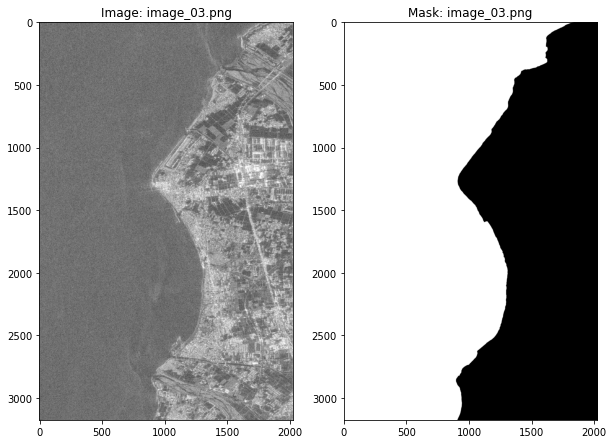

In [ ]:
# 動作確認　学習データとマスクデータの可視化
show_random(ALL_IMAGES, ALL_MASKS)

## 2.5 Datasetクラスの実装と動作確認

以下のデータセットは、画像とマスクを読み込んで、オプションでそれらにAugmentationを適用する

In [ ]:
class SegmentationDataset(Dataset):
    """
    セマンティックセグメンテーション用のDatasetを作成するクラス。
    PyTorchのDatasetクラスを継承。

    Attributes:
    -----------------------------------------------------
    images : -> list型
            学習データのパス(Pathオブジェクト)を格納したリスト
    masks : -> list型
            マスクデータのパス（Pathオブジェクト）を格納したリスト(デフォルトはNone)
    transforms; -> function型
            実行するtransform関数(デフォルトはNone)
    """
    def __init__(self, images, masks=None, transforms=None):
        """
        Parameters:
        -----------------------------------------------------
        images : -> list型
            学習データのパス(Pathオブジェクト)を格納したリスト
        masks : -> list型
            マスクデータのパス（Pathオブジェクト）を格納したリスト(デフォルトはNone)
        transforms; -> function型
            実行するtransform関数(デフォルトはNone)

        """
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        """ 画像の枚数を返す """
        return len(self.images)

    def __getitem__(self, idx):
        """
        学習データ、マスクデータ、ファイル名をdict型変数resultに格納して、
        戻り値としてresultを返す特殊メソッド

        Return:
        -----------------------------------------------------
        result : -> dict型
            {image: 学習データ、mask: マスクデータ、filname: ファイル名}
        """
        # image_pathはpathlibモジュールのPathオブジェクト
        image_path = self.images[idx]
        # OpenCVで学習データを読み込み、numpy.ndarrayに変換する
        image = cv2.imread(str(image_path))

        # (RGB全部同じなので)1chだけスライスして抽出  (H, W, 1)
        image = image[:, :, 0:1]
        # keyを'image', valueを学習データ(numpy.ndarray)として、dict型変数resultを定義
        result = {"image": image}

        # masksがNoneでなければ、マスクデータを読み込み、result(dict型)に格納する。
        if self.masks is not None:
            mask = cv2.imread(str(self.masks[idx]))
            # (RGB全部同じなので)1chだけスライスして抽出  (H, W)
            mask = mask[:, :, 0]
            # keyを'mask', valueをマスクデータ(numpy.ndarray)として、dict型変数resultに要素を追加
            result["mask"] = mask

        # transformsがNoneでなければ、dict型変数resultをアンパッキングし(**はdict型のアンパッキングオペレータ)、
        # imageとmaskにtransform関数を実行する
        if self.transforms is not None:
            result = self.transforms(**result)

        # keyを'filename', valueを学習データのファイル名(string型)として、dict型変数resultに要素を追加
        result["filename"] = image_path.name

        return result

In [ ]:
# 動作確認
dataset_ = SegmentationDataset(ALL_IMAGES, ALL_MASKS)
print("Datasetの総数 :", dataset_.__len__())

idx = 10
print("\nデータサイズ: (Height, Width, Channel)")
print(f'image: {dataset_.__getitem__(idx)["image"].shape}\n',
      f'mask: {dataset_.__getitem__(idx)["mask"].shape}')

Datasetの総数 : 25

データサイズ: (Height, Width, Channel)
image: (4556, 8095, 1)
 mask: (4556, 8095)


### 2.5.1 Augmentations

In [ ]:
def pre_transforms(image_size):
    """
    画像をimage_size x image_sizeにリサイズする関数
    検証時に使用する
    """
    #  p : probability of applying the transform. Default: 1.
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    """
    alubumentationsのメソッドを使って、データオーギュメンテーションを行う関数
    transformの動作確認時と、学習時に使用する。

    Returns:
    ------------------------------------
    result : -> list型
        データオーギュメンテーション用のAlubumentationsのメソッドが格納されている。
    """
    result = [
        # 水平方向に反転
        albu.HorizontalFlip(p=0.5),
        # 上下方向に反転
        albu.VerticalFlip(p=0.5),
        # -90°〜90°の範囲で画像を回転させる。
        albu.augmentations.transforms.Rotate(limit=[-90, 90],
                                             interpolation=0, p=0.5),
        # 3x3のグリッドにしてシャッフル
        albu.RandomGridShuffle(grid=(3, 3), p=0.5),
        # ランダムに明るさとコントラストを変える
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        # 弾性変形（歪ませる）
        albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50,
                              interpolation=1, border_mode=4, p=0.5)
    ]
    return result


def resize_transforms(image_size):
    """
    画像をリスケールしたり、ランダムにクロップする関数。
    学習時、動作確認時に使用する。

    Parameters:
    ------------------------------------
    image_size : -> int型
        リスケール後の画像サイズ

    Returns:
    ------------------------------------
    result : -> list型
        ランダムクロップかリスケールさせるAlubumentationのメソッドが格納されている。
    """
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      # 初期画像のアスペクト比を維持したまま、最小辺がmax_sizeと等しくなるように画像をリスケール
      albu.SmallestMaxSize(pre_size, p=1),
      # image_size x image_sizeでランダムにクロップ
      albu.RandomCrop(image_size, image_size, p=1)
    ])

    # image_size x image_sizeでリスケール
    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    # 複数の処理からランダムでどれか１つを適用させたい場合、OneOfを使う。
    # random_cropかrescaleのどちらかをランダムに実行する
    result = [
      albu.OneOf([random_crop, rescale], p=1)
    ]

    return result


def post_transforms():
    """ Tensor化とmaskを3クラスに変換する関数 """
    return [ToTensorV3()]


def compose(transforms_to_compose):
    """ combine all augmentations into single pipeline """
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

## 2.6 Transformの実装と動作確認

### 2.6.1 カスタムTransformの実装と動作確認

In [ ]:
class ToTensorV3(ToTensorV2):
    """
    学習データとマスク画像をtorch.Tensorに変換する。
    さらに、マスク画像を3クラス分類用に変換する。
    ラベル　0:陸　1:海　2:欠損
    alubumentaionsのToTensorV2クラスを継承。

    Attributes:
    ------------------------------------
    lack : -> numpy.ndarray
        Boolean型のnumpy.ndarrayを格納するのに使用する(初期値はNone)

    """

    def __init__(self, always_apply=True, p=1.0):
        """
        Parameters :
        ------------------------------------
        always_apply : -> Boolean型
            p=1と同義(Trueの場合)
        p : -> int型(0≦p≦1)
            transformを適用する確率、デフォルトは1
        """
        super().__init__(always_apply=True, p=1.0)
        self.lack = None

    def apply(self, img, **params):
        """
        学習データに適用するメソッド。
        """
        # 欠損箇所(0)の座標をインスタンス変数lackに格納して保持
        self.lack = np.where(img[:, :, 0] == 0, True, False)
        # 戻り値としてtorch[0,1]に変換したTensorを返す.
        # Numpyはチャネルラスト、PyTorchはチャネルファーストなので、np.transposeで軸の入れ替えを行う。
        return torch.from_numpy(img.transpose(2, 0, 1)).float().div(255)

    def apply_to_mask(self, mask, **params):
        """
        maskに適用するメソッド
        """
        # index値=255 を 1:海 に変換
        mask = np.where(mask == 255, 1, 0)
        # 欠損箇所を 2:欠損 に変換
        mask = np.where(self.lack == True, 2, mask) 

        return torch.from_numpy(mask)

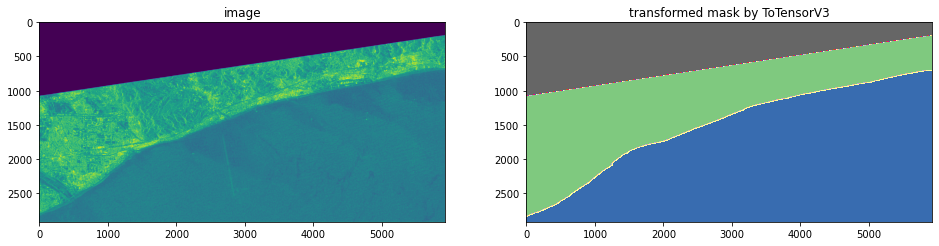

In [ ]:
# ToTensorV3の動作確認
idx = 0
trans_ = ToTensorV3()
temp = trans_(image=dataset_.__getitem__(idx)["image"],
              mask=dataset_.__getitem__(idx)["mask"])

image = temp["image"].detach().cpu().numpy()
mask = temp["mask"].detach().cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(image[0])
ax[0].set_title('image')
ax[1].imshow(mask, cmap="Accent")
ax[1].set_title('transformed mask by ToTensorV3')
plt.show()

学習マスク画像が海、陸、欠損の３クラスに分類されていることが確認できた。

### 2.6.2 学習、検証用のTransformの実装と動作確認

In [ ]:
# 画像サイズ
IMAGE_SIZE_NUM = 640

# 学習用 transformを作成
train_transforms = compose([
    resize_transforms(image_size=IMAGE_SIZE_NUM),
    hard_transforms(),
    post_transforms()
])

# テスト用 transformを作成
test_transforms = compose([pre_transforms(image_size=IMAGE_SIZE_NUM),
                           post_transforms()])

# 検証用 transformを作成
valid_transforms = compose([
    pre_transforms(image_size=IMAGE_SIZE_NUM),
    post_transforms()])

# 動作確認用 transformを作成
show_transforms = compose([resize_transforms(image_size=IMAGE_SIZE_NUM),
                           hard_transforms()])

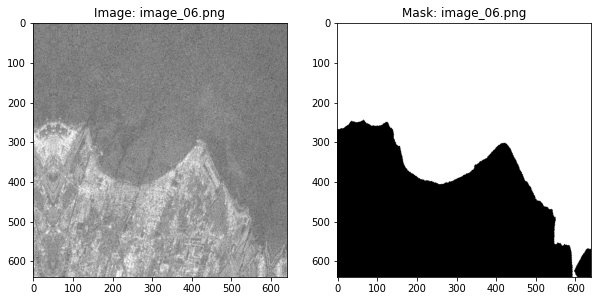

In [ ]:
# 動作確認用 transformを動かす
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

## 2.7 DataLoaderの実装と動作確認

Leave One Group Out :LOGOで学習データと検証データを分割し、DataLoaderを作成する。  
同じシーン=同じグループとして、グループを分割する。  
分割グループの構成は以下の通り。  

グループ |train画像のindex| 枚数
---|---|---
0 | 0, 1 | 2
1 | 2, 3, 4, 5, 6, 7 | 6
2 | 8, 9, 10, 11 | 4
3 | 12, 13 | 2
4 | 14, 15 | 2
5 | 16, 17, 18, 19, 20 | 5
6 | 21, 22 | 2
7 | 23, 24 | 2


In [ ]:
def get_loaders_cross_validation(images, masks,
                                 random_state,
                                 batch_size=5,
                                 num_workers=4,
                                 train_transforms_fn=None,
                                 valid_transforms_fn=None,
                                 multi_num=20):
    """
    LOGOでDataLoaderを作成する関数
    LOGOのFold毎に、OrderedDictにtrainとvalidのDataLoaderを格納していく。
    最後に、戻り値として、OrederedDictをFold毎に格納したリストを返す。

    Parameters:
    ------------------------------------
    images : -> list型
        学習データのパス
    masks : -> list型
        マスクデータのパス
    random_state : -> int型
        乱数シード値
    batch_size : -> int型
        ミニバッチサイズ (デフォルトは5)
    num_workers : -> int型
        ミニバッチを作成する際の並列実行数 (デフォルトは4)
    train_transforms_fn : -> function型
        学習データのtransform関数 (デフォルトはNone)
    valid_transforms_fn : -> function型
        検証データのtransform関数 (デフォルトはNone)
    multi_num : -> int型
        train_imageの枚数を水増しする倍数 (デフォルトは20)

    Returns:
    ------------------------------------
    loaders : -> trainとvalidのOrderedDictを、fold毎に格納したリスト
                list(OrderedDict({train}: train_loader, {valid}: valid_loader), .....):

    """
    # グループ分割交差検証(Leave One Group Out: LOGO))
    logo = LeaveOneGroupOut()
    # グループは手動で設定
    scene = [0]*2 + [1]*6 + [2]*4 + [3]*2 + [4]*2 + [5]*5 + [6]*2 + [7]*2

    # ここにOrderedDictを格納していき、最後にreturnで返す。
    loaders = []

    # Leave One Group Out-CVで、学習データ, マスクデータをそれぞれをtrainとvalidに分割
    for train_index, test_index in logo.split(images, masks, groups=scene):
        train_images = np.array(images)[train_index].repeat(multi_num)
        train_masks = np.array(masks)[train_index].repeat(multi_num)
        val_images = np.array(images)[test_index].repeat(multi_num)[:6]
        val_masks = np.array(masks)[test_index].repeat(multi_num)[:6]

        # 訓練用Datasetを作成
        train_dataset = SegmentationDataset(images=train_images.tolist(),
                                            masks=train_masks.tolist(),
                                            transforms=train_transforms_fn)
        # 検証用Datasetを作成
        valid_dataset = SegmentationDataset(images=val_images.tolist(),
                                            masks=val_masks.tolist(),
                                            transforms=valid_transforms_fn)

        # 訓練用DataLoaderを作成
        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  drop_last=True)

        # 検証用DataLoaderを作成
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=num_workers,
                                  drop_last=True)

        # 学習と検証では、Catalystを使用する。
        # そのため、DataLoaderはOrderedDictで格納する必要がある。
        loader = collections.OrderedDict()
        loader["train"] = train_loader
        loader["valid"] = valid_loader
        loaders.append(loader)

    return loaders

In [ ]:
# グループ分割交差検証の結果を確認
multi_num = 20

logo = LeaveOneGroupOut()
scene = [0]*2 + [1]*6 + [2]*4 + [3]*2 + [4]*2 + [5]*5 + [6]*2 + [7]*2

for train_index, test_index in logo.split(ALL_IMAGES, ALL_MASKS, groups=scene):
    print("TRAIN:", train_index, "TEST:", test_index)
    print('IMAGE-----------------------')
    print(np.array(ALL_IMAGES)[train_index].repeat(multi_num)[:])
    print(np.array(ALL_IMAGES)[train_index].repeat(multi_num).shape)
    print(np.array(ALL_IMAGES)[test_index])
    print('MASK-----------------------')
    print(np.array(ALL_MASKS)[train_index].repeat(multi_num)[:])
    print(np.array(ALL_MASKS)[train_index].repeat(multi_num).shape)
    print(np.array(ALL_MASKS)[test_index])
    print('-----------------------------------------------------------------')


TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [0 1]
IMAGE-----------------------
[PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/train_image/image_02.png')
 PosixPath('/gdrive/My Drive/Colab Notebooks

In [ ]:
# 画像の枚数を20倍に水増し
multi_num = 20
# ミニバッチサイズ
batch_size = 5
print(f"batch_size: {batch_size}")

# DataLoadersの作成
DataLoaders = get_loaders_cross_validation(images=ALL_IMAGES,
                                           masks=ALL_MASKS,
                                           random_state=SEED,
                                           train_transforms_fn=train_transforms,
                                           valid_transforms_fn=valid_transforms,
                                           batch_size=batch_size,
                                           multi_num=multi_num)

batch_size: 5


In [ ]:
# DataLoadersの戻り値を確認
print(DataLoaders)

[OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f98967889e8>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f9896788b00>)]), OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f989675b668>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f989675b198>)]), OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f989675b6a0>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f989675bc18>)]), OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f989674d208>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f989674d940>)]), OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f989674dc50>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f989674da90>)]), OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f989674ddd8>), ('valid', <torch.utils.data.dataloader.DataLoader obj

In [ ]:
# DataLoadersの動作確認
for idx, loaders in enumerate(DataLoaders):
    print(f'dataloader: {idx}')
    batch_iterator = iter(loaders['train'])
    ret = next(batch_iterator)
    print(ret.keys())
    print(ret["image"].shape, ret["mask"].shape)
    print('---------------------------------')

dataloader: 0
dict_keys(['image', 'mask', 'filename'])
torch.Size([5, 1, 640, 640]) torch.Size([5, 640, 640])
---------------------------------
dataloader: 1
dict_keys(['image', 'mask', 'filename'])
torch.Size([5, 1, 640, 640]) torch.Size([5, 640, 640])
---------------------------------
dataloader: 2
dict_keys(['image', 'mask', 'filename'])
torch.Size([5, 1, 640, 640]) torch.Size([5, 640, 640])
---------------------------------
dataloader: 3
dict_keys(['image', 'mask', 'filename'])
torch.Size([5, 1, 640, 640]) torch.Size([5, 640, 640])
---------------------------------
dataloader: 4
dict_keys(['image', 'mask', 'filename'])
torch.Size([5, 1, 640, 640]) torch.Size([5, 640, 640])
---------------------------------
dataloader: 5
dict_keys(['image', 'mask', 'filename'])
torch.Size([5, 1, 640, 640]) torch.Size([5, 640, 640])
---------------------------------
dataloader: 6
dict_keys(['image', 'mask', 'filename'])
torch.Size([5, 1, 640, 640]) torch.Size([5, 640, 640])
--------------------------

## 2.8 損失関数の実装

In [ ]:
class MulticlassDiceLoss(nn.Module):
    """
    Multiクラス対応のDiceLoss
    nn.moduleを継承
    """
    def __init__(self):
        super(MulticlassDiceLoss, self).__init__()

    def forward(self, input, target):
        """
        DiceLossの計算

        Parameters:
        ---------------------------
        input : -> tuple型
            ネットワークからの入力
        target : -> Tensor型
            正解のアノテーション情報

        Returns:
        ---------------------------
        totalLoss : -> Tensor
            損失の値

        """
        # クラスの数
        C = input.shape[1]

        # DiceLossは、catalyst.contrib.nnからimportした関数
        dice = DiceLoss()
        totalLoss = 0

        # クラスごとに損失を計算して合計
        for i in range(C):
            target_ = (target == i).type(torch.float32)
            diceLoss = dice(input[:, i], target_)
            totalLoss += diceLoss

        return totalLoss


class MulticlassIoULoss(nn.Module):
    """
    Multiクラス対応のIoULoss
    nn.moduleを継承
    """
    def __init__(self):
        super(MulticlassIoULoss, self).__init__()

    def forward(self, input, target):
        """
        IoULossの計算

        Parameters:
        ---------------------------
        input : -> tuple型
            ネットワークからの入力
        target : -> Tensor型
            正解のアノテーション情報

        Returns:
        ---------------------------
        totalLoss : -> Tensor
            損失の値
        """
        # クラスの数
        C = input.shape[1]

        # IoULossは、catalyst.contrib.nnからimportした関数
        iou = IoULoss()
        totalLoss = 0

        # クラスごとに損失計算
        for i in range(C):
            target_ = (target == i).type(torch.float32)
            iouLoss = iou(input[:, i], target_)
            totalLoss += iouLoss
        return totalLoss

### 2.8.1 epoch数、logの保存先を設定、GPUの確認

In [ ]:
# epoch数
num_epochs = 8

# Fold毎にlogdirを用意する
logdir_header = 'segmentation_1101_LOGO'
logdirs = [f"{ROOT}/logs/{logdir_header}_{i}" for i in range(1, 9)]

# logdirのイテレーションを確認
for logdir in logdirs:
    print(logdir)

# GPUが使えるか確認
device = utils.get_device()
print(f"device: {device}")


/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_1
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_2
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_3
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_4
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_5
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_6
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_7
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_8
device: cuda


### 2.8.2 Tensorboardの呼び出し

In [ ]:
#Tensorboardの呼び出し https://qiita.com/tetrar124/items/aa27b4d616c859860d02
%load_ext tensorboard
#モニタリング用にTensorboardを表示
%tensorboard --logdir '{logdirs[0]}'

Reusing TensorBoard on port 6006 (pid 519), started 0:19:34 ago. (Use '!kill 519' to kill it.)

<IPython.core.display.Javascript object>

## 2.9 学習と検証の実施

In [ ]:
# dataloderとlogdirのイテレーションを確認
for loader, logdir in zip(DataLoaders, logdirs):
    print(loader)
    print(logdir)

OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f98967889e8>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f9896788b00>)])
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_1
OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f989675b668>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f989675b198>)])
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_2
OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f989675b6a0>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f989675bc18>)])
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentation_1101_LOGO_3
OrderedDict([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f989674d208>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7f989674d940>)])
/gdrive/My Drive/Colab Notebooks/signate/Tellus4/code/logs/segmentat

In [ ]:
%%time
# zip関数でDataLoaderとlogdirを取り出し、学習と推論を実施する
# イテレーションの回数は、LOGOで分割した数。
for loader, logdir in zip(DataLoaders, logdirs):

    # イテレーション毎に、損失関数、モデル、ハイパーパラメータ、スケジューラ、Optimizerを設定する。

    # 損失関数の設定
    criterion = {
        "dice": MulticlassDiceLoss(),
        "iou": MulticlassIoULoss(),
        # 複数クラスなのでBCEからクロスエントロピーに変更
        "ce": nn.CrossEntropyLoss()}

    # 学習済モデルの読み込み
    model = smp.FPN(encoder_name="efficientnet-b5", classes=3, in_channels=1)

    # 転移学習（ファインチューニング）の設定
    learning_rate = 0.001
    encoder_learning_rate = 0.0005

    # 事前に訓練されたエンコーダを使用しているので、学習率を下げていく。
    layerwise_params = {"encoder*": dict(lr=encoder_learning_rate,
                                         weight_decay=0.00003)}

    # This function removes weight_decay for biases and applies our layerwise_params
    model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

    # Optimizerの設定。RAdamを使用
    base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
    optimizer = Lookahead(base_optimizer)

    # スケジューラーの設定
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

    # CatalystのSurpervisedRunnerのインスタンスを生成
    # このインスタンスのrunnerメソッドにmodelや損失関数等を引数で与えることで、PyTorchでの学習と検証の実装が容易になる。
    runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

    # callbackの設定
    callbacks = [
        # Each criterion is calculated separately.
        CriterionCallback(
            input_key="mask",
            prefix="loss_dice",
            criterion_key="dice"),

        CriterionCallback(
            input_key="mask",
            prefix="loss_iou",
            criterion_key="iou"),

        CriterionCallback(
            input_key="mask",
            prefix="loss_ce",
            criterion_key="ce"),

        # And only then we aggregate everything into one loss.
        MetricAggregationCallback(
            prefix="loss",
            mode="weighted_sum",
            # because we want weighted sum, we need to add scale for each loss
            metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_ce": 0.8}),
    ]

    # runner.trainで学習と検証を実施
    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loaders=loader,
        callbacks=callbacks,
        logdir=logdir,
        num_epochs=num_epochs,
        fp16=None,
        verbose=True,
    )

1/8 * Epoch (train):   0% 0/92 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/catalyst/callbacks/optimizer.py:140: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



1/8 * Epoch (train): 100% 92/92 [02:39<00:00,  1.73s/it, loss=2.478, loss_bce=0.153, loss_dice=1.123, loss_iou=1.233]
1/8 * Epoch (valid): 100% 1/1 [00:02<00:00,  2.22s/it, loss=3.188, loss_bce=0.966, loss_dice=0.984, loss_iou=1.432]
[2020-11-06 05:17:47,632] 
1/8 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/8 * Epoch 1 (train): loss=4.1576 | loss_bce=1.0723 | loss_dice=1.5359 | loss_iou=1.7638
1/8 * Epoch 1 (valid): loss=3.1884 | loss_bce=0.9663 | loss_dice=0.9837 | loss_iou=1.4317
2/8 * Epoch (train): 100% 92/92 [02:49<00:00,  1.84s/it, loss=2.414, loss_bce=0.166, loss_dice=1.097, loss_iou=1.185]
2/8 * Epoch (valid): 100% 1/1 [00:02<00:00,  2.22s/it, loss=4.345, loss_bce=1.655, loss_dice=1.376, loss_iou=1.645]
[2020-11-06 05:20:49,058] 
2/8 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/8 * Epoch 2 (train): loss=2.0664 | loss_bce=0.2132 | loss_dice=0.8791 | loss_iou=1.0168
2/8 * Epoch 2 (valid): loss=4.3453 | loss_bce=1.6551 | loss_dice=1.3762 | loss_iou=1.6450
3/8 * Epoch (tra

# 3 コンペ後ディスカッション

## 3.1 Label Smoothingの検討
コンペ上位のアプローチでは、Label Smoothingを使用していた。  
[Label Smoothing](https://deecode.net/?p=1229)とは？  
- Onehot表現の教師データにノイズを加えて過学習防止、性能向上をはかる手法。  
教師データがonehotのような極端な値ではなくなるため、過学習防止につながる。 


In [ ]:
# Label Smoothingの検討
# クロスエントロピーLossにはLabel Smoothingをした方が良かった

# class CE_LabelSmoothing(nn.module()):
#     """
#     Multiクラス対応のIoULoss
#     nn.moduleを継承
#     """
#     def __init__(self):
#         super().__init__()

#     def forward(self, input, target):
#         """
#         IoULossの計算
        
#         Parameters:
#         ---------------------------
#         input : -> tuple型
#             ネットワークからの入力
#         target : -> Tensor型
#             正解のアノテーション情報

#         Returns:
#         ---------------------------
#         totalLoss : -> Tensor
#             損失の値
#         """
#         
#         target = Tensor.where(target==0, 0.1 , 0.9)   # イメージ

#         ce = nn.CrossEntropyLoss()
#         return ce(input, target)